In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
ls

3dbrainviz.ipynb                    fszstatcope2_nvoxels_nz.csv
all_td_age.csv                      fszstatcope2_nvoxels_nz_valset.csv
behav.txt                           git/
fszstatcope2_means_all.csv          glm.ipynb
fszstatcope2_means_nz.csv           sklearn_prelim.ipynb
fszstatcope2_means_nz_valset.csv    valset_behav.csv
fszstatcope2_nvoxels_all.csv


## loading and preprocessing data

In [2]:
voxels = pd.read_csv("fszstatcope2_nvoxels_nz.csv", index_col=0)
behav = pd.read_csv("behav.txt", sep='\t', index_col=0)
print(np.mean(behav.index == voxels.index)) #should be 1.0
voxels_g27 = voxels.iloc[:, (voxels.iloc[1,:] > 27).values]
remove_feature_idx = []

for idx, col in enumerate(voxels_g27.columns):
    for ss in ["Vent", "Stem", "Cerebellum", "CSF", "White", "plexus"]:
        if ss in col:
            remove_feature_idx.append(idx)
            
remove_feature_idx = np.unique(remove_feature_idx)
print(voxels_g27.shape[1] - remove_feature_idx.shape[0]) # should be 58
voxels_data = voxels_g27.iloc[:, np.setdiff1d(np.arange(voxels_g27.shape[1]), remove_feature_idx)]
roi_data = pd.read_csv("fszstatcope2_means_nz.csv", index_col=0).loc[:, voxels_data.columns]
print(np.all(roi_data.columns == voxels_data.columns)) # should be true

# validation set
vset_roi_data = pd.read_csv("fszstatcope2_means_nz_valset.csv", index_col=0).loc[:, voxels_data.columns]
vset_voxel_data = pd.read_csv("fszstatcope2_nvoxels_nz_valset.csv", index_col=0).loc[:, voxels_data.columns]
vbehav = pd.read_csv("valset_behav.csv", index_col=0)

1.0
58
True


## removing linear effect of covaries from roi data

In [143]:
def projection(data , covars):
    """for removing linear effect of covariates"""
    X, C = data.values, covars.values
    P = np.eye(C.shape[0]) - C.dot(np.linalg.pinv(C.T.dot(C))).dot(C.T)
    return pd.DataFrame(P.dot(X), columns=data.columns, index=data.index)

data = projection(roi_data, behav.loc[:, ["gender", "iq", "composite_motion"]])
vset_data = projection(vset_roi_data, vbehav.loc[:, ["sex","iq", "composite_motion"]])
y_multi_class = behav.young_kid + behav.old_kid*2 + behav.adult*3

## testing ability to cluster, since we know k=3

conclusion: this says nothing

In [200]:
% matplotlib inline
import matplotlib.pyplot as plt
from sklearn import manifold
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import permutation_test_score

# multinomial classification using random forest 

In [190]:
nsplits=20
cv = StratifiedKFold(n_splits=nsplits)
rf_scores = np.zeros(nsplits)

for idx, (train, test) in enumerate(cv.split(data.values, y_multi_class)):
    sc = StandardScaler()
    clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=1000))
    clf.fit(sc.fit_transform(data.values[train]), y_multi_class[train])
    rf_scores[idx] = np.mean(y_multi_class[test] == clf.predict(sc.transform(data.values[test])))

In [193]:
rf_scores.mean()

0.39749999999999996

In [214]:
score, permutation_scores, pvalue = permutation_test_score(
    OneVsRestClassifier(RandomForestClassifier(n_estimators=1000)),
    data.values,
    y_multi_class,
    cv=StratifiedKFold(n_splits=10),
    n_permutations=400,
    n_jobs=4,
    scoring="accuracy"
)

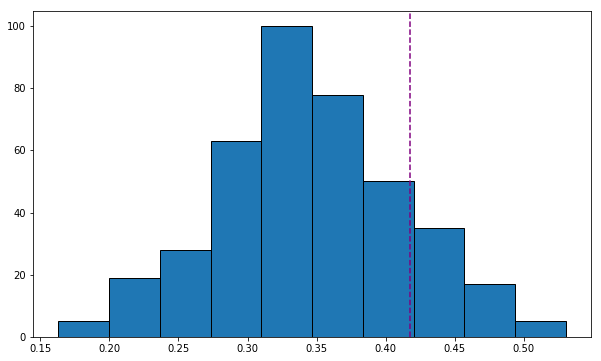

In [215]:
plt.figure(figsize=(10,6))
plt.hist(permutation_scores, edgecolor="black")
plt.axvline(score,ls="--", c="purple")

In [216]:
pvalue

0.14962593516209477

In [217]:
score

0.4174603174603174